In [1]:
import sys
import os

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc30-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from tqdm.notebook import tqdm
from nnpz.photometry import *

In [4]:
will_catalog = sample = Table.read('/home/aalvarez/Work/Data/WillHartley/NNPZ_filter_shift_valid_coherent_noiseless.fits')
print(len(will_catalog))

500000


In [5]:
# Limit the number of sources to recompute
idx = np.random.choice(len(will_catalog), 20000)
sample = will_catalog[idx]

# Set up

In [6]:
class SedProvider(object):
    def __init__(self, basedir):
        self.__basedir = basedir
        self.__cache = dict()
        
    def get_sed(self, name):
        if name not in self.__cache:
            self.__cache[name] = np.genfromtxt(os.path.join(self.__basedir, name))
        return self.__cache[name]

In [7]:
sed_provider = SedProvider('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/')
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
fnuu_prepost = FnuuJyPrePostProcessor()

In [8]:
transmissions = dict()
for filter_name in filter_provider.getFilterNames():
    print(f'Loading {filter_name}')
    transmissions[filter_name] = filter_provider.getFilterTransmission(filter_name)

Loading J
Loading r
Loading z
Loading g
Loading i
Loading Y
Loading u
Loading vis
Loading H


In [9]:
photo_calc = PhotometryCalculator(transmissions, fnuu_prepost)

# Correct sample photometries

In [10]:
for filter_name in transmissions.keys():
    sample[f'Flux_corrected_{filter_name}'] = sample[f'Flux_{filter_name}'] - sample[f'Fluxshift_{filter_name}']

# Compute photometries    

In [11]:
def compute_photometry(row):
    # Get the SED
    original_sed = sed_provider.get_sed(row['SED_name'])

    # Redshift the SED
    sed = original_sed.copy()
    sed[:, 0] *= (1 + row['z'])
    sed[:, 1] /= (1 + row['z'])**2

    # Compute "raw" photometries
    fluxes = photo_calc.compute(sed)
    
    # Compute scale factor using i band
    scale_factor = row['Flux_corrected_i'] / fluxes['i']
    
    # Correct "raw" photometries
    for filter_name in fluxes:
        fluxes[filter_name] *= scale_factor
        
    return fluxes, scale_factor

In [12]:
dtype=[]
for filter_name in transmissions.keys():
    dtype.append((filter_name, '>f4'))
all_photometries = np.zeros((len(sample),), dtype=dtype)
scale = np.zeros((len(sample),))

In [13]:
for i in tqdm(range(len(sample))):
    photo, scale[i] = compute_photometry(sample[i])
    for filter_name in photo:
        all_photometries[filter_name][i] = photo[filter_name]

# Compute diferences

In [14]:
diff = np.zeros(all_photometries.shape, dtype=all_photometries.dtype)

In [15]:
for filter_name in all_photometries.dtype.names:
    #diff[filter_name] = 100.*(all_photometries[filter_name] - sample[f'Flux_corrected_{filter_name}']) / sample[f'Flux_corrected_{filter_name}']
    diff[filter_name] = all_photometries[filter_name] - sample[f'Flux_corrected_{filter_name}']

# Plot

In [16]:
nfilters = len(all_photometries.dtype.names)
ncols = 2
nrows = int(np.ceil(nfilters / ncols))

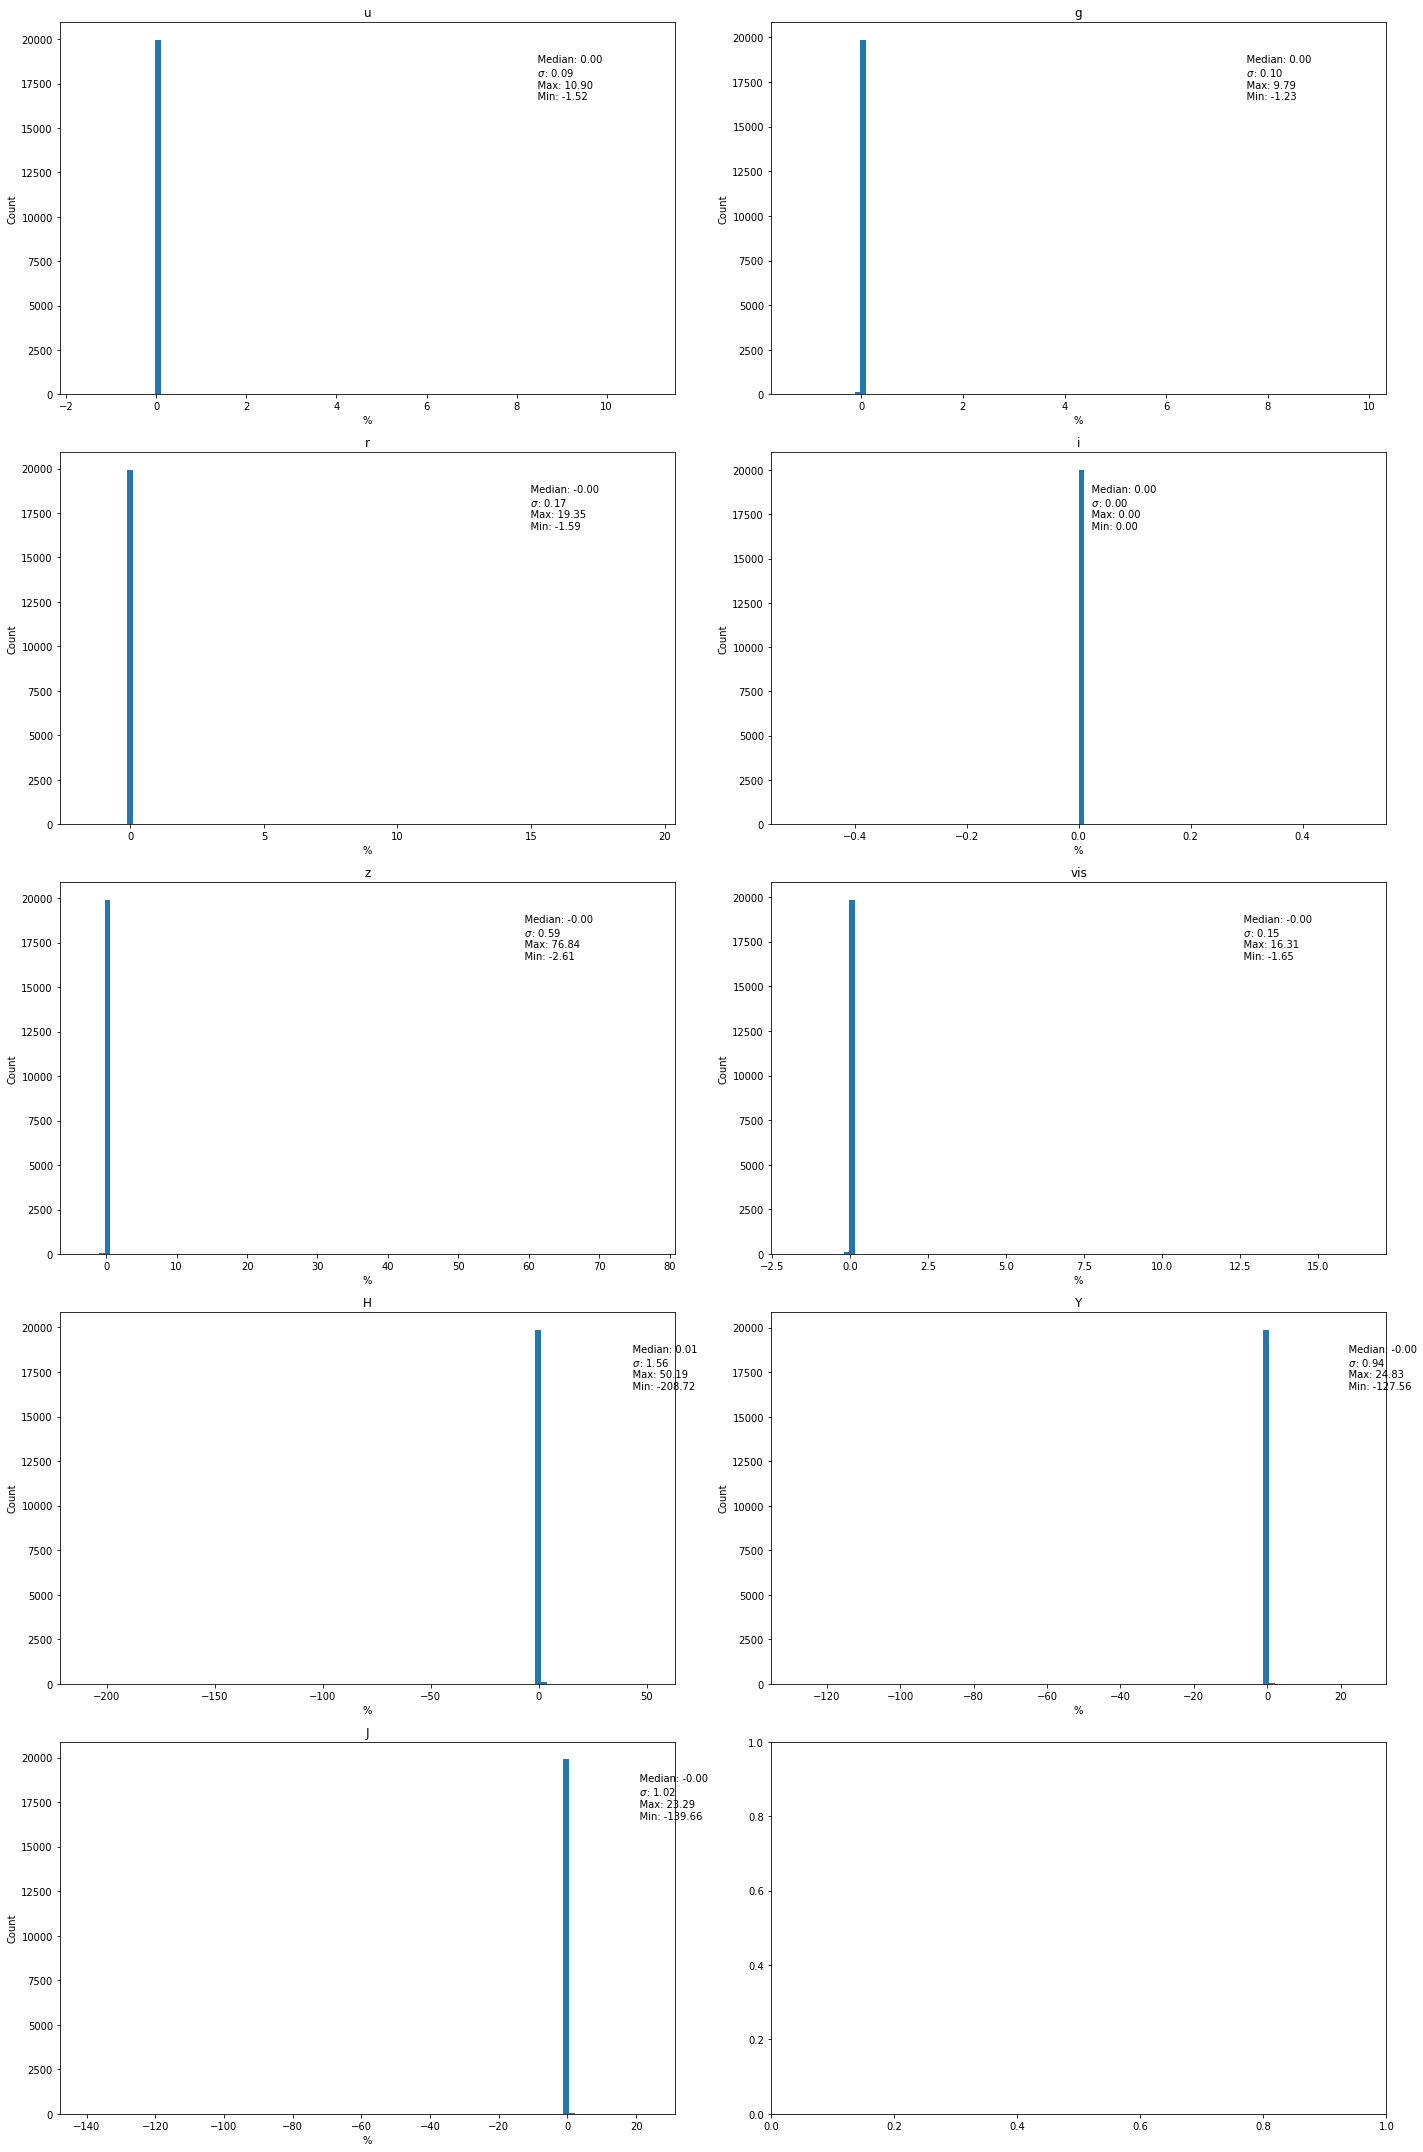

In [17]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.ravel()

for i, filter_name in enumerate(['u', 'g', 'r', 'i', 'z', 'vis', 'H', 'Y', 'J']):
    ax = axes[i]
    counts, _, _ = ax.hist(diff[filter_name], bins=100)
    ax.text(diff[filter_name].max()*0.75, np.max(counts)*0.80, f"""
    Median: {np.median(diff[filter_name]):.2f}
    $\sigma$: {np.std(diff[filter_name]):.2f}
    Max: {np.max(diff[filter_name]):.2f}
    Min: {np.min(diff[filter_name]):.2f}
    """)
    ax.set_title(filter_name)
    ax.set_xlabel('%')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()